## Step0. 필요 라이브러리 설치
아래 라이브러리 설치 후 런타임 재시작

In [ ]:
%%capture
!pip install super-gradients==3.1.1
!pip install imutils
!pip install roboflow
!pip install pytube --upgrade

## Step1. 필요 라이브러리 import & GPU 설정

In [ ]:
import cv2
import torch
from IPython.display import clear_output
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback
from super_gradients.training import models


#-- GPU 설정
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
use_cuda = torch.cuda.is_available()
print(use_cuda)
if use_cuda:
  print(torch.cuda.get_device_name(0))

[2023-06-30 11:15:32] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /root/sg_logs/console.log


/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
[2023-06-30 11:15:36] WARNING - __init__.py - Failed to import pytorch_quantization
[2023-06-30 11:15:36] WARNING - calibrator.py - Failed to import pytorch_quantization
[2023-06-30 11:15:36] WARNING - export.py - Failed to import pytorch_quantization
[2023-06-30 11:15:36] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization


cuda:0
True
Tesla T4


## Step2. 체크포인트 설정

In [ ]:
from super_gradients.training import Trainer
CHECKPOINT_DIR = 'checkpoints'
trainer = Trainer(experiment_name='Pokemon_yolonas_run', ckpt_root_dir=CHECKPOINT_DIR)

In [ ]:
!rm -rf Pokemon
# !rm -rf pokemon-2

## Step3. roboflow 데이터를 코랩으로 가져오기
roboflow에서 복사해뒀던 코드를 붙여넣기

In [ ]:
# !pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="3NnsrtodD4CdBVrs1VJk")
project = rf.workspace("pokmon").project("pokemon-2atdu")
dataset = project.version(1).download("yolov5")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Pokemon-1 in yolov5pytorch:: 100%|██████████| 588/588 [00:00<00:00, 8622.62it/s]


## Step4. 디렉토리로 데이터셋 로드

In [ ]:
dataset_params = {
    'data_dir':'/content/Pokemon-1',
    'train_images_dir':'train/images',
    'train_labels_dir':'train/labels',
    'val_images_dir':'valid/images',
    'val_labels_dir':'valid/labels',
    'test_images_dir':'test/images',
    'test_labels_dir':'test/labels',
    'classes': ['Bulbasaur','Charmander','Squirtle']
}

## Step5. 데이터 parmas를 데이터셋 parmas 인자로 삽입

In [ ]:
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train, coco_detection_yolo_format_val

train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
        # 'show_all_warnings': True
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)


test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

clear_output()

## Step6. 앞에서 정의한 데이터 세트 검사

In [ ]:
train_data.dataset.transforms

[DetectionMosaic('additional_samples_count': 3, 'non_empty_targets': False, 'prob': 1.0, 'input_dim': [640, 640], 'enable_mosaic': True, 'border_value': 114),
 DetectionRandomAffine('additional_samples_count': 0, 'non_empty_targets': False, 'degrees': 10.0, 'translate': 0.1, 'scale': [0.1, 2], 'shear': 2.0, 'target_size': [640, 640], 'enable': True, 'filter_box_candidates': True, 'wh_thr': 2, 'ar_thr': 20, 'area_thr': 0.1, 'border_value': 114),
 DetectionMixup('additional_samples_count': 1, 'non_empty_targets': True, 'input_dim': [640, 640], 'mixup_scale': [0.5, 1.5], 'prob': 1.0, 'enable_mixup': True, 'flip_prob': 0.5, 'border_value': 114),
 DetectionHSV('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 1.0, 'hgain': 5, 'sgain': 30, 'vgain': 30, 'bgr_channels': (0, 1, 2), '_additional_channels_warned': False),
 DetectionHorizontalFlip('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 0.5, 'max_targets': 120),
 DetectionPaddedRescale('swap': (2, 0, 1),

In [ ]:
train_data.dataset.dataset_params['transforms'][1]

{'DetectionRandomAffine': {'degrees': 10.0, 'translate': 0.1, 'scales': [0.1, 2], 'shear': 2.0, 'target_size': [640, 640], 'filter_box_candidates': True, 'wh_thr': 2, 'area_thr': 0.1, 'ar_thr': 20}}

In [ ]:
train_data.dataset.dataset_params['transforms'][1]['DetectionRandomAffine']['degrees'] = 10.42

## Step7. 증폭 기능이 적용된 훈련 데이터 시각화

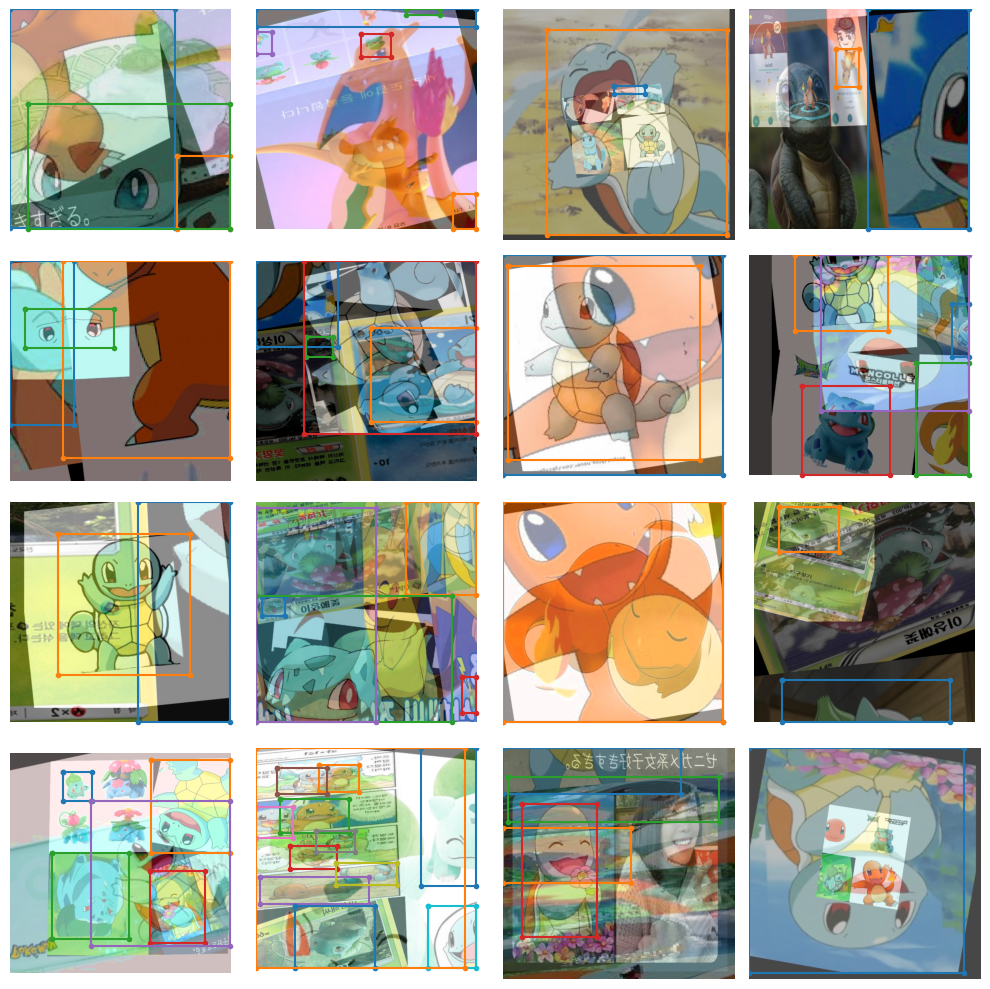

In [ ]:
train_data.dataset.plot()

## Step8. 모델 인스턴스화

다음은 미세 조정을 위해 모델을 인스턴스화하는 방법이다 여기에 `num_classes` 인수를 추가해야 한다는 점에 유의해야 한다.

이 튜토리얼에서는 `yolo_nas_s`를 사용하지만, 슈퍼 그레이디언트에는 두 가지 다른 종류의 yolo_nas_m`과 `yolo_nas_l`를 사용할 수 있다.

In [ ]:
model = models.get('yolo_nas_l',
                   num_classes=len(dataset_params['classes']),
                   pretrained_weights="coco"
                   )

  0%|          | 0.00/256M [00:00<?, ?B/s]

[2023-06-30 12:26:04] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
Downloading: "https://sghub.deci.ai/models/yolo_nas_l_coco.pth" to /root/.cache/torch/hub/checkpoints/yolo_nas_l_coco.pth


## Step9. 모델 하이퍼 파라미터 설정
- `max_epochs` - 최대 훈련 에포크 수

- `loss` - 사용하려는 손실 함수
- `optimizer` - 사용하려는 손실 함수

- `train_metrics_list` - 트레이닝 중에 기록할 메트릭

- `valid_metrics_list` - 트레이닝 중에 기록할 메트릭

- `metric_to_watch` - 모델 체크포인트가 저장될 지표

다음과 같은 다양한 `옵티마이저` 중에서 선택할 수 있다: Adam, AdamW, SGD, Lion 또는 RMSProps. 이러한 옵티마이저의 잘못된 파라미터를 변경하려면 해당 파라미터를 `optimizer_params`에 전달한다.


In [ ]:
train_params = {
    # ENABLING SILENT MODE
    'silent_mode': True,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    # 이 예제의 경우 15개의 에포크만 교육한다.
    "max_epochs": 150,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        # 참고: num_classes는 여기에 정의되어야 한다.
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            # 참고: num_classes는 여기에 정의되어야 한다.
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

## Step10. 모델 학습

In [ ]:
trainer.train(model=model,
              training_params=train_params,
              train_loader=train_data,
              valid_loader=val_data)

[2023-06-30 12:27:24] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}


The console stream is now moved to checkpoints/Pokemon_yolonas_run/console_Jun30_12_27_24.txt


[2023-06-30 12:27:27] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Dataset size:                 252        (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             16         (num_gpus * batch_size)
    - Effective Batch size:         16         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         15         (len(train_loader))
    - Gradient updates per epoch:   15         (len(train_loader) / batch_accumulate)

[2023-06-30 12:27:52] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/Pokemon_yolonas_run/ckpt_best.pth
[2023-06-30 12:27:52] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.006942370440810919
[2023-06-30 12:28:23] INFO - base_sg_logger.py - Checkpoint saved in ch

SUMMARY OF EPOCH 50
├── Training
│   ├── Ppyoloeloss/loss = 1.8755
│   │   ├── Best until now = 1.8716 (↗ 0.0039)
│   │   └── Epoch N-1      = 1.9065 (↘ -0.031)
│   ├── Ppyoloeloss/loss_cls = 0.9317
│   │   ├── Best until now = 0.9272 (↗ 0.0045)
│   │   └── Epoch N-1      = 0.9451 (↘ -0.0134)
│   ├── Ppyoloeloss/loss_dfl = 1.1743
│   │   ├── Best until now = 1.1648 (↗ 0.0094)
│   │   └── Epoch N-1      = 1.193  (↘ -0.0187)
│   └── Ppyoloeloss/loss_iou = 0.1427
│       ├── Best until now = 0.1448 (↘ -0.0021)
│       └── Epoch N-1      = 0.146  (↘ -0.0033)
└── Validation
    ├── F1@0.50 = 0.079
    │   ├── Best until now = 0.0813 (↘ -0.0023)
    │   └── Epoch N-1      = 0.0813 (↘ -0.0023)
    ├── Map@0.50 = 0.7308
    │   ├── Best until now = 0.7758 (↘ -0.045)
    │   └── Epoch N-1      = 0.6473 (↗ 0.0834)
    ├── Ppyoloeloss/loss = 2.2258
    │   ├── Best until now = 2.2406 (↘ -0.0148)
    │   └── Epoch N-1      = 2.4122 (↘ -0.1864)
    ├── Ppyoloeloss/loss_cls = 0.9754
    │   ├── Best

## Step11. 최고의 모델 얻기

In [ ]:
best_model = models.get('yolo_nas_l',
                        num_classes=len(dataset_params['classes']),
                        checkpoint_path="checkpoints/Pokemon_yolonas_run/ckpt_best.pth")

[2023-06-30 13:38:51] INFO - checkpoint_utils.py - Successfully loaded model weights from checkpoints/Pokemon_yolonas_run/ckpt_best.pth EMA checkpoint.


## Step12. 모델 평가

In [ ]:
trainer.test(model=best_model,
            test_loader=test_data,
            test_metrics_list=DetectionMetrics_050(score_thres=0.1,
                                                   top_k_predictions=300,
                                                   num_cls=len(dataset_params['classes']),
                                                   normalize_targets=True,
                                                   post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01,
                                                                                                          nms_top_k=1000,
                                                                                                          max_predictions=300,
                                                                                                          nms_threshold=0.7)
                                                  ))

Test:   0%|          | 0/1 [00:00<?, ?it/s]

{'PPYoloELoss/loss_cls': 1.1895111,
 'PPYoloELoss/loss_iou': 0.18805905,
 'PPYoloELoss/loss_dfl': 1.5324703,
 'PPYoloELoss/loss': 2.4258938,
 'Precision@0.50': tensor(0.0471),
 'Recall@0.50': tensor(0.9333),
 'mAP@0.50': tensor(0.7845),
 'F1@0.50': tensor(0.0884)}

Test: 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


## Step13. 모델 예측

In [ ]:
#-- 테스트 동영상 다운로드
!gdown "https://drive.google.com/uc?id=1HsCBy8HU0Rqs-nb_mScRXVmLwrY1G3UQ"

Downloading...
From: https://drive.google.com/uc?id=1HsCBy8HU0Rqs-nb_mScRXVmLwrY1G3UQ
To: /content/pokemon.mp4
100% 1.40M/1.40M [00:00<00:00, 190MB/s]


In [ ]:
input_video_path = f"/content/pokemon.mp4"
output_video_path = "detections.mp4"

best_model.to(device)
best_model.predict(input_video_path, conf = 0.3).save(output_video_path)

Predicting Video: 100%|██████████| 1126/1126 [00:46<00:00, 24.07it/s]


In [ ]:
from IPython.display import HTML
from base64 import b64encode
import os

# Input video path
save_path = '/content/detections.mp4'

# Compressed video path
compressed_path = "/content/result_compressed.mp4"

os.system(f"ffmpeg -i {save_path} -vcodec libx264 {compressed_path}")

# Show video
mp4 = open(compressed_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)